OK, THIS IS MY ATTEMPT TO ACTUALLY IMPLEMENT THE BINARY VERSION
(BUT THERE ARE STILL REMNANTS OF THINGS I WROTE FOR THE MULTICLASS ONE)


Mallapragada, Pavan Kumar, et al. "Semiboost: Boosting for semi-supervised learning." Pattern Analysis and Machine Intelligence, IEEE Transactions on 31.11 (2009): 2000-2014.

http://www.cse.msu.edu/prip/ResearchProjects/cluster_research/papers/MSU-CSE-07-197.pdf

http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.380.9291&rep=rep1&type=pdf

An AdaBoost Algorithm for Multiclass Semi-Supervised Learning
Jafar Tanha, Maarten van Someren, Hamideh Afsarmanesh

http://dare.uva.nl/document/2/118115



Option to store Sim matrix - though this is huge in my case

In [242]:
import numpy as np

from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import rbf_kernel

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_blobs, make_classification, make_gaussian_quantiles, make_circles
from sklearn.preprocessing import label_binarize

from sklearn.metrics import log_loss, accuracy_score, roc_auc_score
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.dummy import DummyClassifier

from sklearn.utils.extmath import cartesian

from scipy.stats import rv_discrete
from numpy.core.umath_tests import inner1d    # We use this for row wise dot prod

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[-1  1]
K=2
(100,)
(1900,)


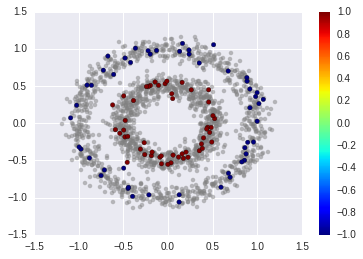

In [705]:
# Prepping dataset
X, y = make_circles(n_samples=2000, factor=0.5, noise=0.08, random_state=322)
y[y==0] = -1

classes = np.unique(y)
K = float(len(classes))
print classes

train_split, val_split = iter(StratifiedShuffleSplit(
    y, n_iter=1, test_size=0.95, random_state=0)).next()
X_train, X_val = X[train_split], X[val_split]
y_train, y_val = y[train_split], y[val_split]

print 'K=%d' % K
plt.scatter(X_val[:,0], X_val[:,1], c='gray', lw=0, alpha=0.5);
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='jet');
plt.colorbar()
print train_split.shape
print val_split.shape

In [706]:
class WeightedAvgClf(BaseEstimator, ClassifierMixin):
    def __init__(self, ests=None, alpha=None):
        if ests is None:
            self.ests = []
        else:
            self.ests = ests
        if alpha is None:
            self.alpha = []
        else:
            self.alpha = alpha
        
    def add_est(self, est, alpha):
        self.ests.append(est)
        self.alpha.append(alpha)

    def fit(self, X, y, **fit_params):
        print 'The estimators should be pre-fit'
        return self

    def predict_proba(self, X, **pred_params):
        if len(self.ests) == 0:
            n_classes = 2  # binary label assumption
            # Return uniform probs if no estimators are stored
            return (1./n_classes) * np.ones((len(X), n_classes))
        else:
            preds = np.array([est.predict_proba(X) for est in self.ests])
            preds_w = (np.array(self.alpha)[:, None, None] * preds).sum(axis=0)
            return preds_w / preds_w.sum(axis=1)[:, None]
    
    def predict(self, X, **pred_params):
        """
        I dont like how this disregards prob, but lets roll with it
        """
        if len(self.ests) == 0:
            return np.zeros(len(X))
        else:
            preds = np.array([est.predict(X) for est in self.ests])
            preds_w = (np.array(self.alpha)[:, None] * preds).sum(axis=0)
            return preds_w
        
        

In [707]:
# Baseline
# clf = DecisionTreeClassifier()
clf = DecisionTreeClassifier(max_depth=1)
# clf = LogisticRegression()
clf.fit(X_train, y_train)
print 'LL:', log_loss(y_val, clf.predict_proba(X_val))
print 'Acc:', accuracy_score(y_val, clf.predict(X_val))

LL: 1.04037598597
Acc: 0.639473684211


In [708]:
# Just playing with pairwise for similarity
# S = pairwise_distances(X, metric='cosine', n_jobs=-1)
# S = pairwise_distances(X, metric='euclidean', n_jobs=-1)
S = rbf_kernel(X, gamma=10)


# TODO: confirm that this reshape is doing what I expect
cart_lu = cartesian([train_split, val_split])
cart_uu = cartesian([val_split, val_split])
S_lu = S[cart_lu[:,0], cart_lu[:,1]].reshape([len(train_split), len(val_split)])
S_uu = S[cart_uu[:,0], cart_uu[:,1]].reshape([len(val_split), len(val_split)])

print X.shape
print S.shape
print S_lu.shape
print S_uu.shape


(2000, 2)
(2000, 2000)
(100, 1900)
(1900, 1900)


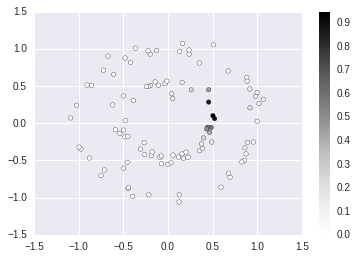

In [709]:
plt.scatter(X_train[:,0], X_train[:,1], c=S_lu[:,5])
plt.colorbar()

In [738]:
# Mallapragada p & q
y_l = y_train
y_u = y_val
C = float(len(y_l)) / len(y_u)
print 'C =', C

def get_confidence(y_l, H_pred_u,
                   S_lu, S_uu,
                   C = float(len(y_l))/len(y_u),
                   pred_type='lbl'):
    """
    THIS ASSUMES +1 / -1 LABELING SCHEME
    
    y_l: labeled targets
    H_pred_u: predictions for unlabeled observations
        (I think label predictions rather than probabilities???)
    S_lu: similarity matrix of labeled & unlabeled
    S_uu: similarity matrix of unlabeled observations onto itself
    C: importance weight between the labeled and the unlabeled data
    pred_type: 'lbl' - +/-1 label or 'prob' - probability of label being +1
    """
    if pred_type == 'prob':
        H_pred_u = H_pred_u - 0.5  # rather than -= which will modify in place
    
    H_u_tile = np.tile(H_pred_u[:, None], len(H_pred_u))

    # p
    p_left = (S_lu[np.where(y_l == +1)[0], :] * \
              np.exp(-2 * H_pred_u)).sum(axis=0)
    p_right = (C/2.)*(S_uu * np.exp(H_u_tile - H_u_tile.T)).sum(axis=0)
    p = p_left + p_right

    q_left = (S_lu[np.where(y_l == -1)[0], :] * \
              np.exp(+2 * H_pred_u)).sum(axis=0)
    q_right = (C/2.)*(S_uu * np.exp(H_u_tile.T - H_u_tile)).sum(axis=0)
    q = q_left + q_right

    return p, q


def get_clf_weight(h_pred_u, p, q):
    """
    THIS ASSUMES +1 / -1 LABELING SCHEME
    """
    
    num = p[h_pred_u == +1].sum() + q[h_pred_u == -1].sum()
    den = p[h_pred_u == -1].sum() + q[h_pred_u == +1].sum()
    alpha = 0.25 * np.log(num / den)
    return alpha

    

C = 0.0526315789474


In [792]:
accs = []
lls = []

# clf = DecisionTreeClassifier()
clf = DecisionTreeClassifier(max_depth=1)   # Decision stump
# clf = LogisticRegression()

H = WeightedAvgClf()

T = 100
for t in range(T):
    print 'Iter:', t,
    H_predprob_u = H.predict_proba(X_val)
    H_pred_u = H.predict(X_val)
    
    try:
        ll = log_loss(y_val, H_predprob_u),
    except ValueError:
        ll = np.nan,
    acc = accuracy_score(y_val, np.sign(H_pred_u))
    roc = roc_auc_score(y_val, H_pred_u)
    print '\t\tLL:',  np.round(ll, 3),
    print '\t\tAcc:', np.round(acc, 3),
    print '\t\tROC:', np.round(roc, 3)
    accs.append(acc)
    lls.append(ll)
#     --------------------------------------------------------------    
    p, q = get_confidence(y_train, H_pred_u,
                   S_lu, S_uu,
                   C = float(len(X_train))/len(X_val))
#     p, q = get_confidence(y_train, H_predprob_u[:,1],
#                    S_lu, S_uu,
#                    C = float(len(X_train))/len(X_val),
#                    pred_type='prob')
    
    z = np.sign(p - q)
    # NOTE: paper calls for just np.abs(p-q) .. I wanted it to be more influencial
    w = np.exp(np.abs(p - q))
    u_sampling_pmf = rv_discrete(values=(range(len(w)), w / w.sum()))
#     --------------------------------------------------------------    
    # Sample the pseudo-labels based on confidence
    # Mallapragada uses 10% | Tanha uses 15%
    p_xfer = 0.1
    n_xfer = int(len(w) * p_xfer)
    xfer_inds = u_sampling_pmf.rvs(size=n_xfer)
    y_xfer_all = z    # Pseudo labels all
    y_xfer = y_xfer_all[xfer_inds]   # Pseudo labels for xfers
    X_xfer = X_val[xfer_inds, :]

    # Fit the component classifier
    h = clone(clf).fit(
        X=np.r_[X_train, X_xfer],
        y=np.r_[y_train, y_xfer],
    )
    
    # Predict again using just component classifier
#     h_pred_u = h.predict_proba(X_val)
    h_pred_u = h.predict(X_val)
#     h_pred_l = h.predict_proba(X_train)
    
#     --------------------------------------------------------------
    # Weighted error term for new component classifier h
    alpha_t = get_clf_weight(h_pred_u, p, q)
    print 'alpha_t: %g' % alpha_t
    if alpha_t <= 0:
        print 'alpha_t is negative -- breaking at iter %d' % t
        break
    
#     --------------------------------------------------------------
    
    H.add_est(h, alpha_t)

Iter: 0 		LL: [ 0.693] 		Acc: 0.0 		ROC: 0.5
alpha_t: 0.12107
Iter: 1 		LL: [ 1.284] 		Acc: 0.639 		ROC: 0.639
alpha_t: 0.0898064
Iter: 2 		LL: [ 0.703] 		Acc: 0.639 		ROC: 0.751
alpha_t: 0.0532986
Iter: 3 		LL: [ 0.612] 		Acc: 0.555 		ROC: 0.869
alpha_t: 0.0357463
Iter: 4 		LL: [ 0.598] 		Acc: 0.641 		ROC: 0.871
alpha_t: 0.029487
Iter: 5 		LL: [ 0.583] 		Acc: 0.559 		ROC: 0.871
alpha_t: 0.0301853
Iter: 6 		LL: [ 0.563] 		Acc: 0.672 		ROC: 0.871
alpha_t: 0.0352482
Iter: 7 		LL: [ 0.551] 		Acc: 0.577 		ROC: 0.951
alpha_t: 0.0274838
Iter: 8 		LL: [ 0.546] 		Acc: 0.68 		ROC: 0.951
alpha_t: 0.0261158
Iter: 9 		LL: [ 0.545] 		Acc: 0.577 		ROC: 0.956
alpha_t: 0.023565
Iter: 10 		LL: [ 0.545] 		Acc: 0.68 		ROC: 0.956
alpha_t: 0.0259029
Iter: 11 		LL: [ 0.546] 		Acc: 0.68 		ROC: 0.954
alpha_t: 0.0212144
Iter: 12 		LL: [ 0.544] 		Acc: 0.68 		ROC: 0.954
alpha_t: 0.031511
Iter: 13 		LL: [ 0.542] 		Acc: 0.679 		ROC: 0.969
alpha_t: 0.0221414
Iter: 14 		LL: [ 0.543] 		Acc: 0.681 		ROC: 0.969
alpha_t

In [743]:
# y_val
# np.sign(H_pred_u)
H.predict(X_val)


array([ 0.58400844,  0.09405606,  0.61062327, ...,  0.86638912,
        0.61062327,  0.30270633])

In [433]:
# plt.figure(figsize=(16, 8))
# plt.plot(np.array(accs)*100)
# plt.plot(np.array(lls)*5)

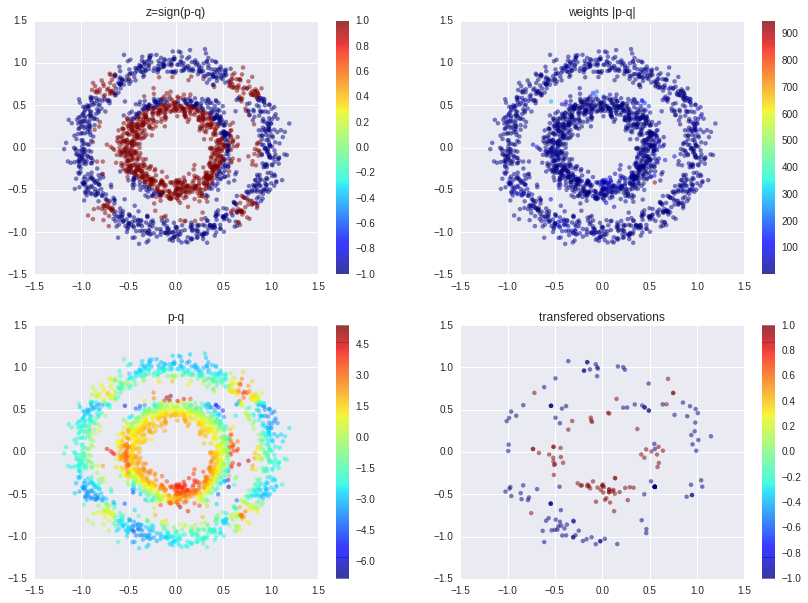

In [793]:
plt.figure(figsize=(14,10))
plt.subplot(221)
plt.scatter(X_val[:,0], X_val[:,1], c=z, lw=0, alpha=0.5, cmap='jet')
plt.colorbar()
plt.title('z=sign(p-q)')

plt.subplot(222)
plt.scatter(X_val[:,0], X_val[:,1], c=w, lw=0, alpha=0.5, cmap='jet')
plt.colorbar()
plt.title('weights |p-q|')

plt.subplot(223)
plt.scatter(X_val[:,0], X_val[:,1], c=p-q, lw=0, alpha=0.5, cmap='jet')
plt.colorbar()
plt.title('p-q')

plt.subplot(224)
plt.scatter(X_xfer[:,0], X_xfer[:,1], c=y_xfer, lw=0, alpha=0.5, cmap='jet')
plt.colorbar()
plt.title('transfered observations')




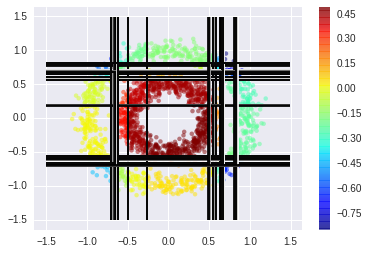

In [794]:
# Plot the decision boundaries

plot_step = 0.01
x_min, x_max = -1.5, +1.5
y_min, y_max = -1.5, +1.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

for ii in range(T):
    Z = H.ests[ii].predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
#     cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=.5)
    cs = plt.contour(xx, yy, Z)
plt.scatter(X_val[:,0], X_val[:,1], c=(H.predict(X_val)), lw=0, alpha=0.5, cmap='jet')
plt.colorbar()

In [384]:
p_xfer = 0.1
n_xfer = int(len(w) * p_xfer)
xfer_inds = u_sampling_pmf.rvs(size=n_xfer)
y_xfer_all = z    # Pseudo labels all
y_xfer = y_xfer_all[xfer_inds]   # Pseudo labels for xfers
X_xfer = X_val[xfer_inds, :]

# Fit the component classifier
h = clone(clf).fit(
    X=np.r_[X_train, X_xfer],
    y=np.r_[y_train, y_xfer],
)


In [419]:
S = rbf_kernel(X)

cart_lu = cartesian([train_split, val_split])
cart_uu = cartesian([val_split, val_split])
S_lu = S[cart_lu[:,0], cart_lu[:,1]].reshape([len(train_split), len(val_split)])
S_uu = S[cart_uu[:,0], cart_uu[:,1]].reshape([len(val_split), len(val_split)])


False

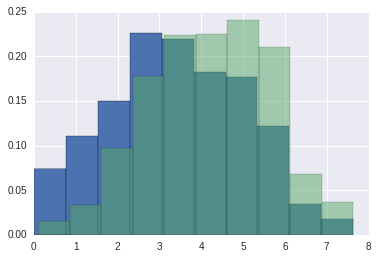

In [780]:

xfer_inds = u_sampling_pmf.rvs(size=10000)

# print sorted(w[xfer_inds])

plt.hist(w, normed=True);
plt.hist(w[xfer_inds], alpha=0.5, normed=True);

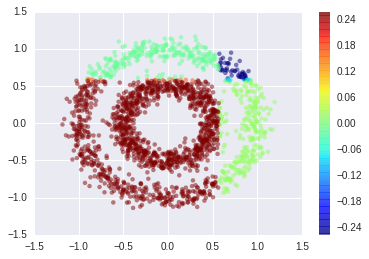

In [791]:
plt.scatter(X_val[:,0], X_val[:,1], c=H.predict(X_val), lw=0, alpha=0.5, cmap='jet')
plt.colorbar()

In [725]:
preds = np.array([est.predict(X) for est in H.ests])
preds_w = (np.array(H.alpha)[:, None] * preds).sum(axis=0)
# return preds_w

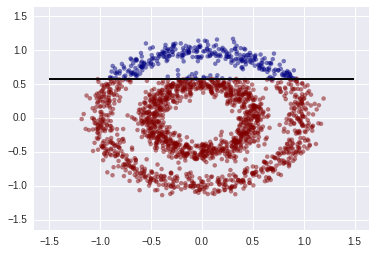

In [778]:
ii = 8
Z = H.ests[ii].predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contour(xx, yy, Z)

plt.scatter(X_val[:,0], X_val[:,1], c=H.ests[ii].predict(X_val), lw=0, alpha=0.5, cmap='jet')
